# 코드 설명

이 코드는 TensorFlow를 사용하여 CIFAR-10 데이터셋으로 Generative Adversarial Network (GAN) 모델을 훈련시키고, 생성된 이미지를 GIF로 변환하
는 과정을 포함합니다. 코드는 다음과 같은 주요 단계를 포함합니다:

1. CIFAR-10 데이터셋 로드 및 전처리

2. 생성자(generator)와 판별자(discriminator) 모델의 정의

3. 손실 함수와 최적화 함수 설정

4. 훈련 스텝 구현 및 미니 배치 훈련

5. 훈련 과정에서 이미지 생성 및 저장

6. 체크포인트를 통한 모델 저장 및 복원

7. 훈련 과정의 이미지로 GIF 파일 생성

In [420]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
from IPython.display import clear_output
from IPython.display import Image

In [421]:
# CIFAR-10 데이터셋 로드 및 전처리
cifar10 = tf.keras.datasets.cifar10  # CIFAR-10 데이터셋 로드

In [422]:
(train_x, _), (test_x, _) = cifar10.load_data()  # 훈련 및 테스트 데이터 분리

In [423]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')  # 이미지 차원 재조정 및 데이터 타입 변경

In [424]:
train_x = (train_x - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화합니다.

In [425]:
def make_generator_model():
    # 생성자 모델 정의
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    #기존코드
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #개선코드
    #model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [426]:
generator = make_generator_model()  # 생성자 모델 인스턴스 생성

In [427]:
def make_discriminator_model():
    # 판별자 모델 정의
    model = tf.keras.Sequential()
    #개선코드
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [428]:
discriminator = make_discriminator_model()  # 판별자 모델 인스턴스 생성

In [429]:
# 손실 함수와 최적화 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # 이진 교차 엔트로피 손실 함수

In [432]:
def discriminator_loss(real_output, fake_output):
    # 판별자 손실 함수 정의
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # 가짜 이미지에 대한 패널티 추가
    # fake_penalty = 0.1 * tf.reduce_mean(tf.square(fake_output)) # 패널티 계수는 실험적으로 조정할 수 있습니다.
    total_loss = real_loss + fake_loss
    #total_loss = real_loss + fake_loss + fake_penalty
    #real_loss = tf.reduce_mean(tf.square(real_output - 1))
    #fake_loss = tf.reduce_mean(tf.square(fake_output))
    #total_loss = 0.5 * (real_loss + fake_loss)
    return total_loss

In [433]:
def generator_loss(fake_output):
    # 생성자 손실 함수 정의
    # return cross_entropy(tf.ones_like(fake_output), fake_output)
    return 0.5 * tf.reduce_mean(tf.square(fake_output - 1))

LSGAN방식을 생성자만 적용하였습니다

(LSGAN : LSGAN은 손실 함수를 least squares loss로 대체하여 그라디언트 소실 문제를 줄이는 것이 목적)

In [434]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # 생성자 최적화 함수

In [435]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  # 판별자 최적화 함수

In [436]:
# 버퍼 사이즈와 배치 사이즈 설정
BUFFER_SIZE = 60000  # 버퍼 사이즈
BATCH_SIZE = 256  # 배치 사이즈

In [437]:
# 배치 데이터를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [438]:
def draw_train_history(history, epoch):
    # 손실 그래프
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('Model Loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Batch Iterations')  
    plt.legend(['Gen Loss', 'Disc Loss'], loc='upper left')  

    # 정확도 그래프
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('Discriminator Accuracy')  
    plt.ylabel('Accuracy')  
    plt.xlabel('Batch Iterations')  
    plt.legend(['Fake Accuracy', 'Real Accuracy'], loc='upper left')  

    # 이미지 저장
    plt.savefig(f'{os.getenv("HOME")}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{epoch:04d}.png')
    plt.show()

In [439]:
# 하나의 미니배치 훈련 과정
@tf.function
def train_step(images):
    # 훈련 스텝 정의
    noise = tf.random.normal([BATCH_SIZE, 100])  # 랜덤 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 생성자를 통한 이미지 생성

        real_output = discriminator(images, training=True)  # 실제 이미지의 판별 결과
        fake_output = discriminator(generated_images, training=True)  # 생성된 이미지의 판별 결과
        
        # 기존코드
        gen_loss = generator_loss(fake_output)  # 생성자 손실 계산
        disc_loss = discriminator_loss(real_output, fake_output)  # 판별자 손실 계산
        
        # 정확도 계산 로직 추가
        fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.0, tf.float32))
        real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.0, tf.float32))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # 생성자 손실에 대한 기울기 계산
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # 판별자 손실에 대한 기울기 계산

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # 생성자 업데이트
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # 판별자 업데이트
    
    return gen_loss, disc_loss, fake_accuracy, real_accuracy

In [440]:
# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, it, sample_seeds):
    # 생성된 이미지 저장 함수 정의
    predictions = model(sample_seeds, training=False)

    # 이미지 데이터를 [0, 1] 범위로 조정
    predictions = (predictions + 1) / 2.0  # [-1, 1] 범위를 [0, 1] 범위로 변경합니다.

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i], cmap=None)  # cmap 인자를 제거합니다.
        plt.axis('off')
   
    # 이미지 파일 저장 경로를 설정합니다.
    # os.getenv('HOME')은 환경변수에서 HOME 경로를 가져옵니다. 실제 서버에 맞게 경로를 설정하세요.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [441]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'  # 체크포인트 디렉토리 설정

In [442]:
num_examples_to_generate = 16  # 생성할 이미지 수
noise_dim = 100  # 노이즈 차원
seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 시드 노이즈 생성
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")  # 체크포인트 파일 접두사

In [443]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)  # 체크포인트 설정

In [444]:
latest = tf.train.latest_checkpoint(checkpoint_dir)  # 최신 체크포인트 로드
checkpoint.restore(latest)  # 체크포인트 복원

In [445]:
generator = checkpoint.generator  # 생성자 로드

In [446]:
discriminator = checkpoint.discriminator  # 판별자 로드

In [447]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])  # 랜덤 노이즈 생성
generated_image = generator(noise, training=False)  # 생성된 이미지

In [448]:
# TensorFlow 텐서를 NumPy 배열로 변환
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5

# NumPy 배열에 astype 메서드 적용
np_generated = np_generated.astype(np.uint8)

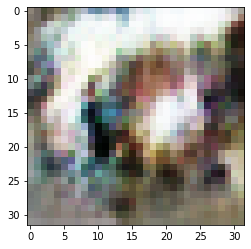

In [449]:
plt.imshow(np_generated[0])
plt.show() # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [450]:
# GAN 모델의 전체 훈련 과정을 정의합니다. 각 에포크마다 이미지를 생성하고 모델의 상태를 저장합니다.
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}

    for epoch in range(epochs):
        epoch_start = time.time()

        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)

            # 손실 및 정확도 기록
            history['gen_loss'].append(gen_loss.numpy())
            history['disc_loss'].append(disc_loss.numpy())
            history['real_accuracy'].append(real_accuracy.numpy())
            history['fake_accuracy'].append(fake_accuracy.numpy())

            if it % 50 == 0:
                clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f'Epoch {epoch + 1} | Iteration {it + 1}')
                print(f'Time for epoch {epoch + 1}: {int(time.time() - epoch_start)} sec')

        # 에포크 종료 후 체크포인트 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, it, seed)
        print(f'Total training time: {int(time.time() - start)} sec')

        draw_train_history(history, epoch + 1)

In [451]:
# 훈련에 사용할 변수들 초기화
# 개선사향 기존 EPOCHS = 50 -> 100
EPOCHS = 50
save_every = 5

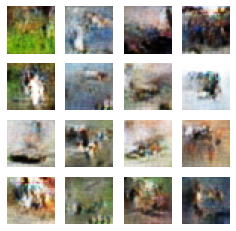

Total training time: 756 sec


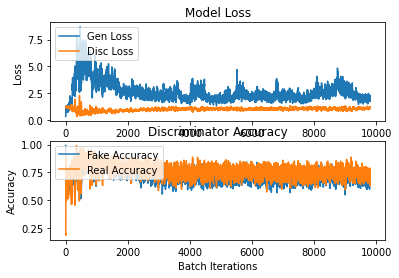

CPU times: user 12min 58s, sys: 1min 1s, total: 14min
Wall time: 12min 37s


In [452]:
%%time
train(train_dataset, EPOCHS, save_every)

In [33]:
# GIF 생성을 위한 이미지 저장
def create_gif():
    anim_file = 'cifar10.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('image*.png')
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)


In [34]:
# GIF 생성
create_gif()

In [35]:
# GIF 생성위치 확인
current_directory = os.getcwd()
print("현재 작업 디렉토리:", current_directory)

현재 작업 디렉토리: /aiffel/aiffel


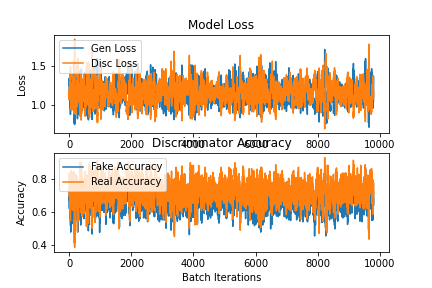

In [45]:
Image('/aiffel/aiffel/dcgan_newimage/cifar10/training_history/train_history_0050.png')

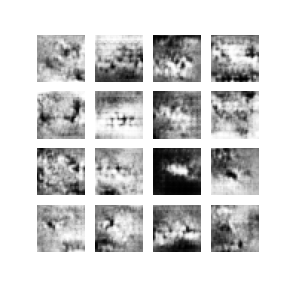

In [46]:
Image('/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0050_iter_195.png')

# 생성된 이미지 샘플 분석

이미지들이 흐리고 구별하기 어려운 특징들을 보여줍니다.
이는 생성기가 데이터의 다양성을 충분히 학습하지 못했거나, 모델이 아직 수렴하지 않았음을 의미할 수 있습니다.

# 학습 과정 그래프 분석

손실 그래프: 생성기와 판별기의 손실이 높게 유지되며 큰 변동성을 보이고 있습니다. 
이는 GAN이 안정적인 상태에 도달하지 못했음을 나타냅니다.

정확도 그래프: 진짜와 가짜에 대한 판별기의 정확도가 50% 부근에서 큰 변동성을 보이는 것으로 보아,
판별기가 진짜와 가짜를 구별하는데 어려움을 겪고 있음을 시사합니다. 
이상적인 상황에서는 판별기의 정확도가 진짜와 가짜에 대해 각각 50%에 가까워야 하는데, 이는 판별기가 무작위로 추측하고 있음을 의미합니다.

# 문제점 및 개선 방안

모델 아키텍처: 생성기의 아키텍처를 개선할 필요가 있습니다. 더 많은 층을 추가하거나, 더 깊은 네트워크를 시도해 볼 수 있습니다.
또한, 생성기와 판별기의 균형을 맞추기 위해 판별기의 용량을 줄이는 것도 고려해 볼 수 있습니다.

학습률 및 최적화: 학습률을 조정하거나 다른 최적화 알고리즘을 시도할 수 있습니다. 
예를 들어, 생성기와 판별기에 서로 다른 학습률을 적용해 볼 수 있습니다.

정규화 기법: 과적합을 방지하고 학습 과정을 안정화하기 위해 드롭아웃이나 배치 정규화를 추가할 수 있습니다.

학습 과정: 학습 과정에서 더 많은 에포크를 진행하거나, 더 자주 이미지를 생성하여 생성기의 진행 상황을 더 자세히 모니터링할 수 있습니다.

# 개선코드

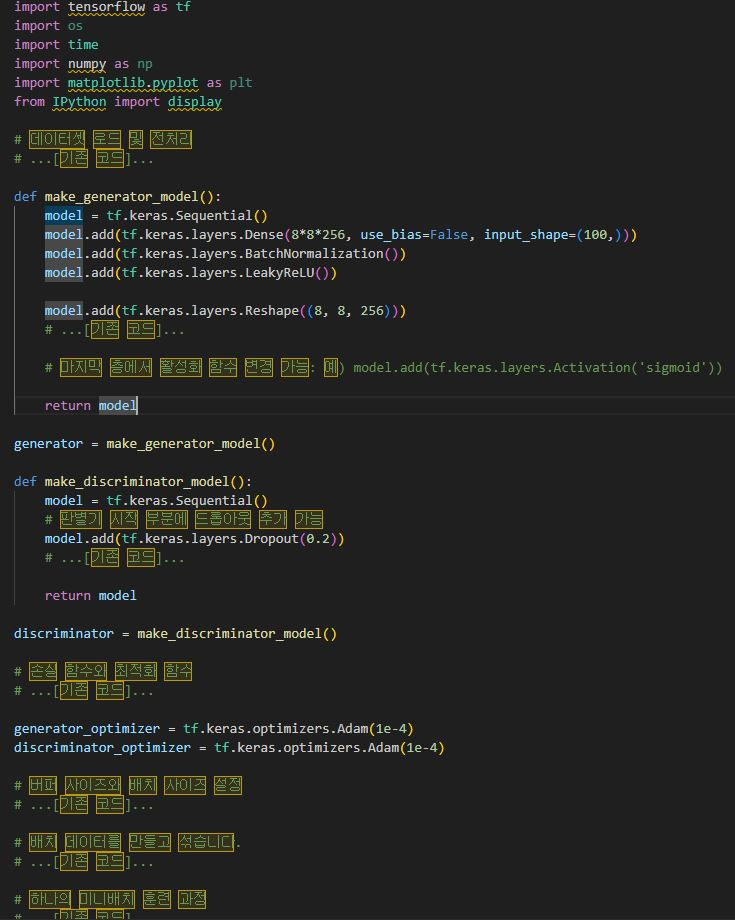

In [42]:
Image('/aiffel/aiffel/img1.JPG')

sigmoid함수를 사용할때는 이미지의 노이즈가 너무 커서 포기함

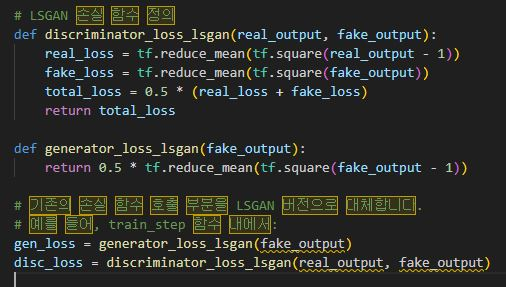

In [82]:
Image('/aiffel/aiffel/img2.JPG')

회고 : 판별기와 생성기의 중간지점에서 만나서 가짜와 진짜를 구분하는 그래프가 이상적인 그래프지만 그런 그래프를 구현하려고
다방면으로 찾아보았지만 해결하지못해서 많이 아쉽다 그러나 이런저런 방법들이 많이 있다는 것을 알아서 얻어가는 것도 많았던
프로젝트인것 같다 